In [1]:
import pandas as pd
import numpy as np

import math as mt
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.preprocessing import MinMaxScaler

# from statsforecast.models import AutoARIMA, AutoETS, SeasonalNaive
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings("ignore")

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox, het_white
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera

import time

In [3]:
df = pd.read_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/total_cpi_MinMaxScaler.csv')
df['ds'] = pd.to_datetime(df['ds'])

df = df.rename(columns={'ws': 'y'})

end_train_start_test = int(len(df) * .85)
train_index, test_index = range(end_train_start_test), range(end_train_start_test, len(df))
Y_train_df, Y_test_df = df.iloc[train_index], df.iloc[test_index].reset_index(drop=True)

## SARIMA

In [ ]:
sarima = SARIMAX(Y_train_df.y, order=(5, 0, 1), seasonal_order=(1, 0, 0, 52))
results = sarima.fit()

forecast = results.get_forecast(steps=len(test_index))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

In [ ]:
df_forecast = pd.read_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/forecast_neural.csv')
df_forecast['SARIMA'] = forecast_mean.values

df_forecast.to_csv('/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/forecast_neural.csv')

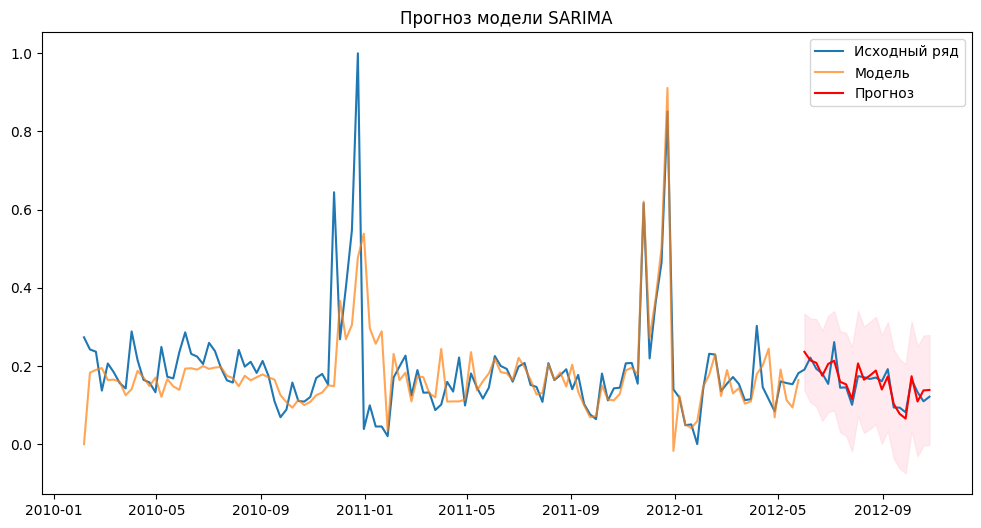

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.ds, df.y, label='Исходный ряд')
plt.plot(df.ds.iloc[:len(train_index)], results.fittedvalues, label='Модель', alpha=.7)
plt.plot(df.ds.iloc[len(train_index):], forecast_mean, color='r', label='Прогноз')
plt.fill_between(df.ds.iloc[len(train_index):],
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Прогноз модели SARIMA')
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(Y_test_df.y, forecast_mean.values)
mae = mean_absolute_error(Y_test_df.y, forecast_mean.values)
mape = mean_absolute_percentage_error(Y_test_df.y, forecast_mean.values)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'RMSE: {np.sqrt(mse)}')

MSE: 0.0005633850619477282
MAE: 0.019719430277438568
MAPE: 0.1319174890190894
RMSE: 0.023735733861579428


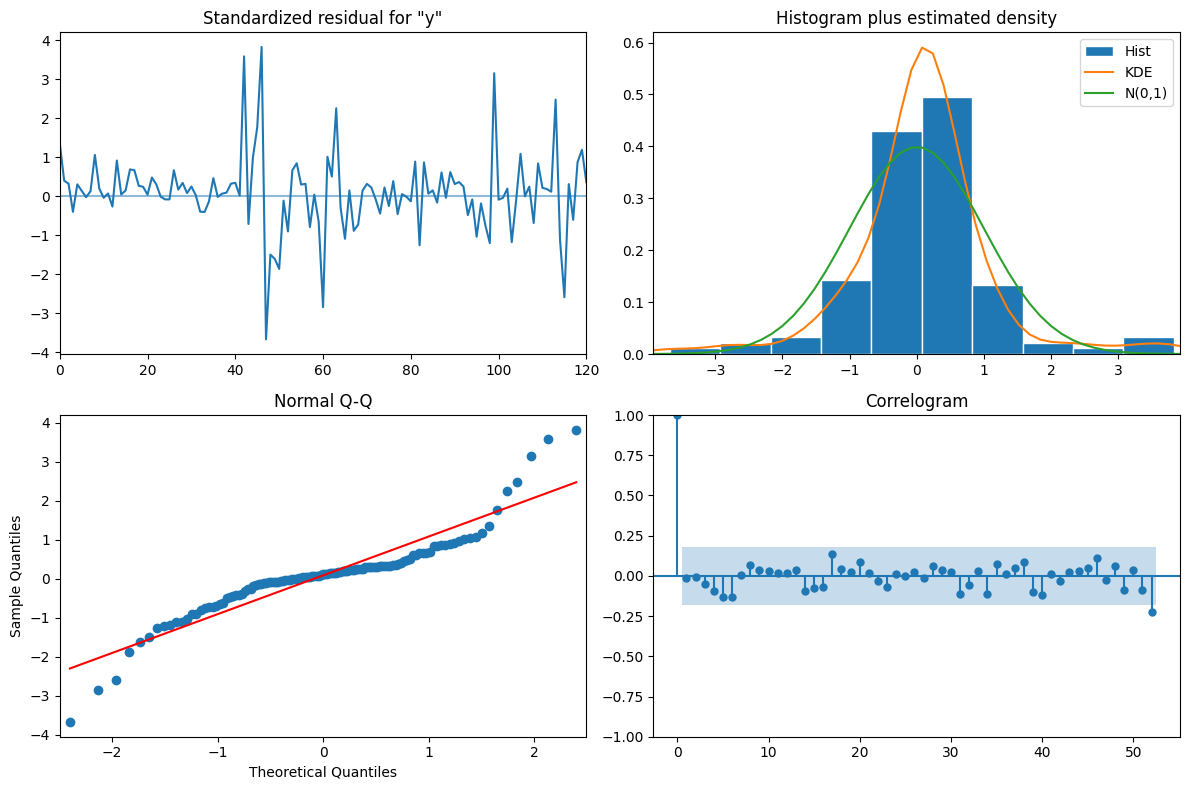

In [ ]:
results.plot_diagnostics(figsize=(12, 8), lags=52)
plt.tight_layout()
plt.show()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  121
Model:             SARIMAX(5, 0, 1)x(1, 0, [], 52)   Log Likelihood                 137.156
Date:                             Fri, 23 May 2025   AIC                           -258.312
Time:                                     13:13:29   BIC                           -235.945
Sample:                                          0   HQIC                          -249.228
                                             - 121                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2795      1.420      0.197      0.844      -2.503       3.062
ar.L2          0.2090      0.616      0.339      0.735      -0.999       1.417
ar.L3          0.1017      0.199      0.510      0.610      -0.289       0.493
ar.L4          0.2612      0.136      1.927      0.054      -0.004       0.527
ar.L5         -0.0591      0.346     -0.171      0.864      -0.737       0.619
ma.L1          0.1652      1.463      0.113      0.910      -2.702       3.033
ar.S.L52       0.9338      0.011     88.572      0.000       0.913       0.955
sigma2         0.0025      0.000      9.211      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               100.22
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               5.36   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## GARCH

https://www.kaggle.com/code/nholloway/volatility-clustering-and-garch

In [ ]:
from statsmodels.stats.diagnostic import het_arch

# lags - количество лагов для теста (обычно 5-10)
test_result = het_arch(results.resid, maxlag=52, ddof=7)
print(f"LM Statistic: {test_result[0]}")
print(f"P-value: {test_result[1]}")
print(f"F Statistic: {test_result[2]}")
print(f"F P-value: {test_result[3]}")


LM Statistic: 30.088404447040116
P-value: 0.9935917073244391
F Statistic: 0.22330665097811128
F P-value: 0.9998547926357888


In [ ]:
sarima_resid = results.resid.dropna()
garch = arch_model(sarima_resid, mean="Zero", vol='FIGARCH', p=0, q=1)
garch_fit = garch.fit()
garch_fit.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -17.537987925703785
Iteration:      2,   Func. Count:     12,   Neg. LLF: -18.21148052223984
Iteration:      3,   Func. Count:     17,   Neg. LLF: -25.072768254869317
Iteration:      4,   Func. Count:     22,   Neg. LLF: -94.29828718724558
Iteration:      5,   Func. Count:     27,   Neg. LLF: -116.54450950738588
Iteration:      6,   Func. Count:     31,   Neg. LLF: -116.18933927156061
Iteration:      7,   Func. Count:     36,   Neg. LLF: -117.18326994934887
Iteration:      8,   Func. Count:     41,   Neg. LLF: -119.09212290563563
Iteration:      9,   Func. Count:     45,   Neg. LLF: -114.04286869254096
Iteration:     10,   Func. Count:     51,   Neg. LLF: -119.79486563830464
Iteration:     11,   Func. Count:     56,   Neg. LLF: -119.82804222037633
Iteration:     12,   Func. Count:     61,   Neg. LLF: -119.83454941651436
Iteration:     13,   Func. Count:     65,   Neg. LLF: -119.83563402607092
Iteration:     14,   Func. Count:     69

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Zero Mean - FIGARCH Model Results                       
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.009
Vol Model:                    FIGARCH   Log-Likelihood:                119.836
Distribution:                  Normal   AIC:                          -233.671
Method:            Maximum Likelihood   BIC:                          -225.436
                                        No. Observations:                  115
Date:                Tue, Apr 22 2025   Df Residuals:                      115
Time:                        09:26:36   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.0866e-03  2.052e-03      1.992  4.640e-02 [6.518e-05,8.108e-03]
d              0.9880      0.190      5.195  2.044e-07     [  0.615,  1.361]
beta           0.0246  9.775e-02      0.251      0.801     [ -0.167,  0.216]
============================================================================

Covariance estimator: robust
"""

In [ ]:
# lags - количество лагов для теста (обычно 5-10)
test_result = het_arch(garch_fit.resid, maxlag=5)
print(f"LM Statistic: {test_result[0]}")
print(f"P-value: {test_result[1]}")
print(f"F Statistic: {test_result[2]}")
print(f"F P-value: {test_result[3]}")

LM Statistic: 33.92350025748627
P-value: 2.4659724389495624e-06
F Statistic: 9.274990407601521
F P-value: 2.508148958665511e-07


## library

In [4]:
from numpy.typing import NDArray
import math as mt
import itertools

### Show

In [5]:
class BaseError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def shapeError(*args):
    for i in range(2, len(args) - 1):
      assert args[i].shape == args[i + 1].shape, BaseError(f'x and y must have same first dimension, {args[i].shape} and {args[i + 1].shape}')


class SubplotError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def all_arg_one_type(*args):
    types = set([type(arg) for arg in args[1:]])
    assert len(types) == 1, SubplotError(f'Arguments don`t have one type')

  @classmethod
  def shapeError(*args):
    BaseError.shapeError(*args)


class Show():
    def __init__(self, base_figsize=(5, 2)) -> None:
        self.fig, self.axes = None, None
        self.shape, self.pos = None, [0, 0]
        self.base_figsize = base_figsize  # базовый размер для одного подграфика

    def create_subplot(self, nrows: int, ncols: int) -> None:
        self.shape = [nrows, ncols]
        # Автоматический расчет размера фигуры на основе количества подграфиков
        fig_width = self.base_figsize[0] * ncols
        fig_height = self.base_figsize[1] * nrows
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))

    def add_subplot(self, xvalue: NDArray, yvalue: NDArray, title = None, xlabel=None, ylabel=None, **kwargs):
        if self.shape[0] == 1 and self.shape[1] == 1:
            self.axes.plot(xvalue, yvalue, **kwargs)
            if title:
              self.axes.set_title(title)
            if xlabel:
              self.axes.set_xlabel(xlabel)
            if ylabel:
              self.axes.set_ylabel(ylabel)
        elif self.shape[0] == 1 or self.shape[1] == 1:
            pos_coord = self.pos[0] if self.shape[0] > 1 else self.pos[1]
            self.axes[pos_coord].plot(xvalue, yvalue, **kwargs)
            if title:
              self.axes[pos_coord].set_title(title)
            if xlabel:
              self.axes[pos_coord].set_xlabel(xlabel)
            if ylabel:
              self.axes[pos_coord].set_ylabel(ylabel)
        else:
            self.axes[self.pos[0], self.pos[1]].plot(xvalue, yvalue, **kwargs)
            if title:
              self.axes[self.pos[0], self.pos[1]].set_title(title)
            if xlabel:
              self.axes[self.pos[0], self.pos[1]].set_xlabel(xlabel)
            if ylabel:
              self.axes[self.pos[0], self.pos[1]].set_ylabel(ylabel)

        if self.pos[1] + 1 < self.shape[1]:
            self.pos[1] += 1
        else:
            self.pos[0] += 1
            self.pos[1] = 0

    def subplot(self, xvalues: NDArray, yvalues: NDArray, nrows: int, ncols: int, titles=None, xlabels=None, ylabels=None):
        SubplotError.shapeError(xvalues, yvalues)
        self.create_subplot(nrows, ncols)

        for i in range(xvalues.shape[0]):
            self.add_subplot(xvalues[i], yvalues[i], titles[i], xlabels[i], ylabels[i])

        plt.subplots_adjust(wspace=0.3, hspace=0.2)
        plt.show()

    def subplot_x(self, yvalues: NDArray, ncols: int, titles=None, xlabels=None, ylabels=None) -> None:
        xvalues = [np.arange(yvalues.shape[1])] * yvalues.shape[0]
        nrows = mt.ceil(yvalues.shape[0] / ncols)
        if titles is None:
          titles = [None] * yvalues.shape[0]
        if xlabels is None:
          xlabels = [None] * yvalues.shape[0]
        if ylabels is None:
          ylabels = [None] * yvalues.shape[0]
        self.subplot(np.array(xvalues), yvalues, nrows, ncols, titles, xlabels, ylabels)

    def one_plot(self, y: NDArray, labels: NDArray, x: NDArray = None, title: str = None) -> None:
        if x is None:
          x = np.array([np.arange(y.shape[1])] * y.shape[0])

        SubplotError.shapeError(x, y)

        for i, yv in enumerate(y):
          plt.plot(x[i], yv, label=labels[i])

        if title:
          plt.title(title)
        plt.legend()
        plt.show()

### GenerateData Analytics

In [6]:
class GenerateDataError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def other_ts(*args):
    for i in range(1, len(args[1:]) - 1):
      assert (args[i].ts != args[i + 1].ts).sum(), GenerateDataError('Diferent time series')

  @classmethod
  def add_error(cls):
    raise GenerateDataError('Error add')

  @classmethod
  def init_param(cls, ts, change, data):
    assert data is not None or (ts is not None and change is not None), GenerateDataError('data or (ts and change) can be not None')


class GenerateData():
  def __init__(self, ts: NDArray = None, change: NDArray = None,  data=None, method: str = 'additive') -> None:
    GenerateDataError.init_param(ts, change, data)
    self.data = data
    if change is not None and ts is not None:
       if method == 'additive':
         self.data = self.additive_date(ts, change)

  def __add__(self, other):
    if isinstance(other, GenerateData):
      GenerateDataError.other_ts(self, other)
      data = np.vstack((self.data, other.data))
      return GenerateData(data=data)
    else:
      GenerateDataError.add_error()

  def additive_date(self, ts: NDArray, change: NDArray):
    ready = [ts + ch for ch in change]
    return np.array(ready)


class Analytics():
  def __init__(self, data: GenerateData, title: NDArray = None) -> None:
     self.title = title
     self.data = data

  def correlogram_compare(self, lags=52, alpha=.05, figsize=(12, 6)) -> None:
    nrows = self.data.shape[0]
    figsize = (figsize[0], figsize[1] * nrows / 3)
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=figsize)
    axes = axes.ravel()
    i_axes = 0

    for i in range(self.data.shape[0]):
      plot_acf(self.data[i],
               lags=lags,
               ax=axes[i_axes],
               alpha=alpha,
               title=f'ACF {self.title[i] if self.title is not None else ""}',
               zero=False)
      plot_pacf(self.data[i],
                lags=lags,
                alpha=alpha,
                ax=axes[i_axes + 1],
                title=f'PACF {self.title[i] if self.title is not None else ""}',
                zero=False)
      i_axes += 2

    # Настройка общего заголовка
    plt.suptitle(f'Correlograms for Time Series Analysis (α={alpha})', y=1.02)
    plt.tight_layout()
    plt.show()

  def correlogram_compare_one(self, lags=52, alpha=.05, figsize=(12, 6)) -> None:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize)

    for i in range(self.data.shape[0]):
      plot_acf(self.data[i],
               lags=lags,
               ax=ax1,
               alpha=alpha,
               title=f'ACF',
               zero=False)
      plot_pacf(self.data[i],
                lags=lags,
                alpha=alpha,
                ax=ax2,
                title=f'PACF',
                zero=False)

    plt.suptitle(f'Correlograms for Time Series Analysis (α={alpha})', y=1.02)
    plt.tight_layout()
    plt.show()

  def plot_ts(self) -> None:
    show = Show()
    show.subplot_x(self.data, 2)

### Split SARIMACompare

In [7]:
class SplitTrainTestError(Exception):
  def __init(self, message):
    super().__init__(message)

  def half(half):
    assert half >= 0 and half <= 1, SplitTrainTestError(f'The half can be belongs to the interval [0, 1]')


class SplitTrainTest():
  def __init__(self, data: GenerateData, half: float | int):
    SplitTrainTestError.half(half)

    self.half = half
    self.data_original = data
    self.train_index, self.test_index = self.__get_split_index(self.data_original.shape[1])
    self.data_split = None

  def __get_split_index(self, len):
    end_train_start_test = int(len * self.half)
    return np.arange(0, end_train_start_test), np.arange(end_train_start_test, len)

  def split(self):
    new_data = [[dt[self.train_index], dt[self.test_index]] for dt in self.data_original]
    self.data_split = new_data
    return self.data_split

  def split_use_signs(self, df_sings):
    self.split()
    x_train, x_test = df_sings.iloc[self.train_index], df_sings.iloc[self.test_index]
    return (x_train, x_test, self.data_split)


class ModelCompare():
  def __init__(self, gd: GenerateData, name: NDArray, df_path: str, df_path_long_forecast: str, columns, step_lf: int):
    self.params = []

    self.split = SplitTrainTest(gd.data, .85)
    self.data = self.split.data_split
    self.name = name
    self.df_path = df_path
    self.df_path_long_forecast = df_path_long_forecast
    self.df = pd.DataFrame(columns=columns)

    if self.df_path_long_forecast is not None:
      self.df_long_forecast = pd.DataFrame(columns=[f'{cl}' for cl in range(step_lf, self.split.test_index.size, step_lf)])


class SARIMACompare(ModelCompare):
  def __init__(self, gd: GenerateData, name: NDArray, df_path: str, df_path_long_forecast: str = None, step_lf=3) -> None:
    columns=['name', 'p', 'n', 'q', 'sp', 'sn', 'sq', 'm', 'aicc', 'bic', 'mae', 'mse']
    super().__init__(gd, name, df_path, df_path_long_forecast, columns, step_lf)
    self.data = self.split.split()

  def build_sarima(self, i_data: int, order: tuple, seasonal_order: tuple):
    train = self.data[i_data][0]
    test = self.data[i_data][1]

    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    result = model.fit()
    forecast = result.forecast(steps=test.size)

    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)

    self.df.loc[self.df.shape[0]] = [self.name[i_data], *order, *seasonal_order, result.aicc, result.bic, mae, mse]
    self.df.to_csv(self.df_path, index=False)

    if self.df_path_long_forecast is not None:
      self.long_forecast(result, test)

  def long_forecast(self, result, test):
    forecast = []
    for step in range(3, test.size, 3):
      fr = result.forecast(steps=step)
      mae = mean_absolute_error(test[:step], fr)
      mse = mean_squared_error(test[:step], fr)
      forecast.append((mae, mse))

    self.df_long_forecast.loc[self.df_long_forecast.shape[0]] = forecast
    self.df_long_forecast.to_csv(self.df_path_long_forecast, index=False)

  def compare(self, size_seasonal, order_list, frequencies, use_seasonal_component=False) -> None:
    p, q = order_list[0], order_list[2]
    d = order_list[1] # np.arange(0, 4)
    order = list(itertools.product(p, d, q))
    seasonal_order = [(0, 0, 0, 0)]
    seasonal_order_frequencies = []

    if use_seasonal_component:
      seasonal_order.append((1, 0, 0, 52))

      # if 52 not in frequencies:
      #   frequencies.append(52)

      # for ss in range(size_seasonal):
      #   if frequencies[ss] == 52:
      #     continue
      #   seasonal_order_frequencies.append([(0, 0, 0, 0)] + [(1, 0, 0, frequencies[ss])])

    seasonal_order_frequencies = seasonal_order.copy()


    print(f'All combinations {len(self.data[:-size_seasonal]) * len(order) * len(seasonal_order) + size_seasonal * len(order) * len(seasonal_order_frequencies)}')
    i_combination = 1
    size_trend = len(self.data) - size_seasonal

    for i_data in range(len(self.data)):
      if i_data < size_trend:
        for s_ord in seasonal_order:
          for ord in order:
            print(f'cimbination {i_combination}')
            self.build_sarima(i_data, ord, s_ord)
            i_combination += 1
      else:
        for s_ord in seasonal_order_frequencies:
          for ord in order:
            print(f'cimbination {i_combination}')
            self.build_sarima(i_data, ord, s_ord)
            i_combination += 1

### SARIMACompareOne (5, 0, 1)(1, 0, 0, 52)

In [8]:
class SARIMACompareOne(SARIMACompare):
  def __init__(self, gd: GenerateData, name: NDArray, df_path: str, df_path_long_forecast: str = None, step_lf=3) -> None:
    super().__init__(gd, name, df_path, df_path_long_forecast, step_lf)

  def compare(self) -> None:
    order = (5, 0, 1)
    seasonal_order = (1, 0, 0, 52)

    print(f'All combinations {len(self.data)}')
    i_combination = 1

    for i_data in range(len(self.data)):
      print(f'cimbination {i_combination}')
      i_combination += 1
      self.build_sarima(i_data, order, seasonal_order)

### BestParams

In [9]:

class BestParams():
  def __init__(self):
    self.df = pd.DataFrame()
    self.df_long_forecast = pd.DataFrame()
    self.best_params = []

  def load(self, path_df, path_df_lf=None):
    self.df = pd.read_csv(path_df)
    if path_df_lf:
      self.df_long_forecast = pd.read_csv(path_df_lf)

  def get_best_params(self, columns_params, sort_by):
    best_params = []
    for name in self.df['name'].unique():
      dff = self.df[self.df['name'] == name]
      dffs = dff.sort_values(by=sort_by, ascending=[True, True]).iloc[0]  # сортируем и берем первую строку
      params = {clp: dffs[clp] for clp in columns_params}
      best_params.append(params)
    return best_params

  def search_best_params(self, columns_params, sort_by=['aicc', 'bic']):
    best_params = self.get_best_params(columns_params, sort_by=sort_by)
    for bp in best_params:
      self.best_params.append(list(bp.values()))
    return self.best_params

  def print(self):
    for bp in self.best_params:
      for i, b in enumerate(bp):
        if i == 0:
          print('[', end='')
        print(b, end='')
        if i == len(bp) - 1:
          print(']')
        else:
          print(', ', end='')

  def __args_plot(self, bp, type_ts, inf_cr, name):
    information_cr, title, labels, x = [[] for _ in range(len(inf_cr))], [], [], []
    for b_dict in bp:
      if type_ts in b_dict[name]:
        for i, cr in enumerate(inf_cr):
          information_cr[i].append(b_dict[cr])
        fb_dict_key = [
            key
            for key in b_dict.keys()
            if key not in [name] + inf_cr
        ]
        title.append((b_dict[k] for k in fb_dict_key))
        x.append(float(b_dict[name].split(type_ts + '=')[-1]))

    for title_name in title:
      string = ''
      for tn in title_name:
        string += str(tn) + ' '
      labels.append(string)
    return information_cr, labels, x

  def plot(self, columns_params, type_ts=['k', 'alpha', 'freq'], inf_cr=['aicc', 'bic'], sort_by=['aicc', 'bic'], name='name', show_labels=False):
    bp = self.get_best_params(columns_params, sort_by=sort_by)
    for t in type_ts:
      information_cr, labels, x = self.__args_plot(bp, t, inf_cr, name)

      for i, cr in enumerate(inf_cr):
        plt.plot(x, information_cr[i], marker='o', label=cr.upper())
      plt.legend()
      plt.title('line trend' if t == 'k' else 'exp trend' if t == 'alpha' else 'sin seasonal')
      if show_labels:
        plt.xticks(x, labels, rotation=45)
      else:
        plt.xlabel(t)
      if len(inf_cr) == 1:
        plt.ylabel(inf_cr[0].upper())
      plt.show()


### GenerteComponents

In [10]:
class GenerateComponents(GenerateData):
  def __init__(self, t: NDArray): # , data: NDArray = np.array([[]])
    # super().__init__(data=data)
    self.t = t

  def gen_line_trend(self, coefficient: NDArray, normalize=True):
    trend = np.array([k * self.t for k in coefficient])
    if normalize:
      trend = trend / trend.max()
    return GenerateData(data=trend)

  def gen_exp_trend(self, alphas: NDArray):
    n = self.t.shape[0]
    trend = []
    for alpha in alphas:
      trend.append([alpha ** (n - i) for i in range(1, n + 1)])

    trend = np.array(trend)
    return GenerateData(data=trend)

  def gen_seasonal(self, freq, coef=1, normalize=True):
    seasonal = np.array([np.sin(2 * np.pi * (1 / f) * self.t) for f in freq])
    if normalize:
      seasonal = seasonal + 1
      seasonal = seasonal / seasonal.max() * coef
    return GenerateData(data=seasonal)

  def generate_all(self, coefficient_lt, alpha_et, freq_s, coef_s):
    line_trend = self.gen_line_trend(coefficient_lt)
    exp_trend = self.gen_exp_trend(alpha_et)
    seasonal = self.gen_seasonal(freq_s, coef_s)
    return line_trend + exp_trend + seasonals

  def additive_components(self, components):
    if not len(components):
      return np.zero_like(t)
    for cmp in components[0]:
      self.additive_components(components[1:])


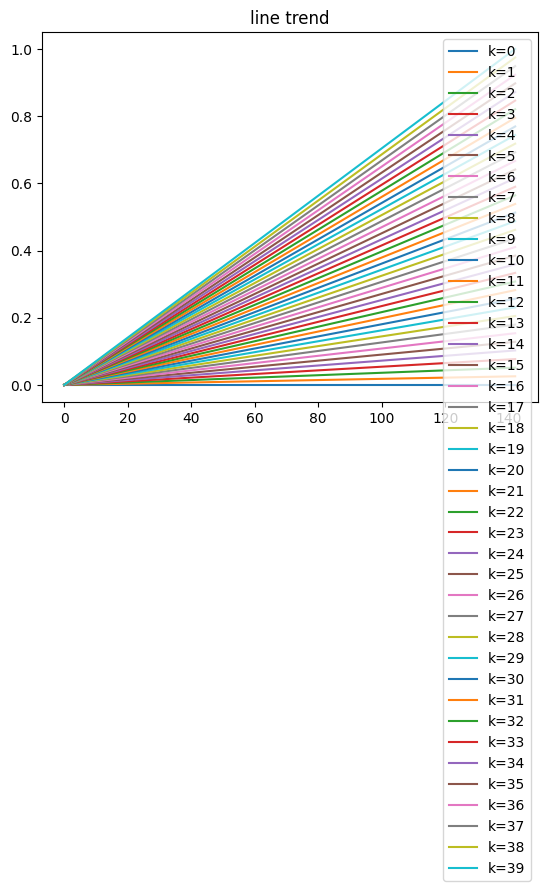

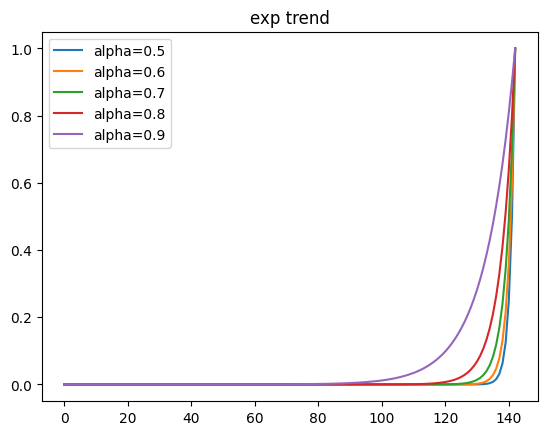

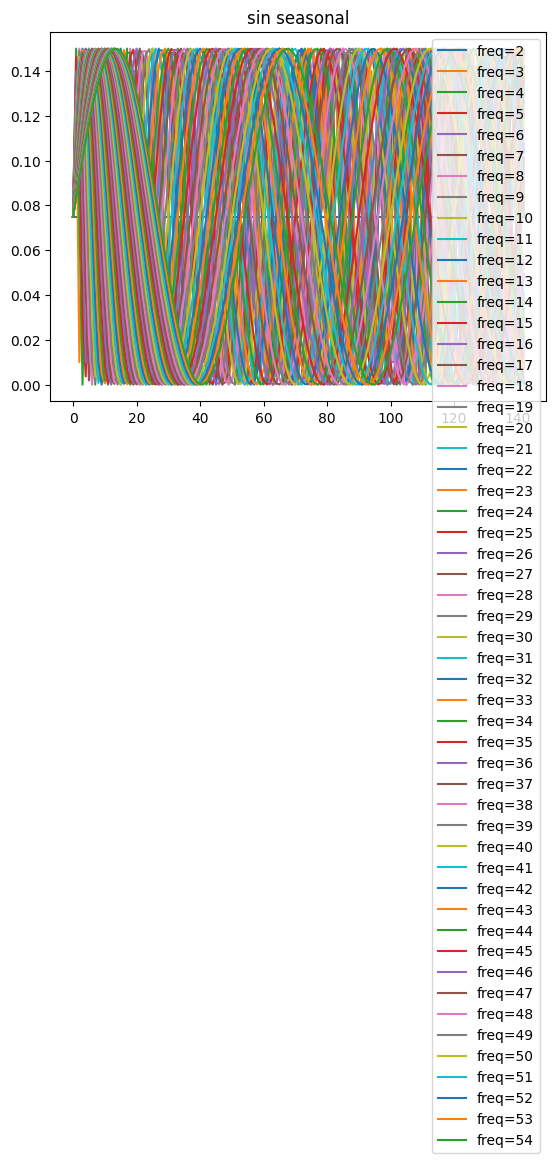

In [11]:
t = np.arange(df.shape[0])
coefficient = np.arange(0, 40)
alphas = np.array([.5, .6, .7, .8, .9])
frequencies = np.arange(2, 55)

gc = GenerateComponents(t)
show = Show()

line_trend = gc.gen_line_trend(coefficient)
name_line_trend = [f'k={c}' for c in coefficient]
show.one_plot(line_trend.data, name_line_trend, title=f'line trend')

exp_trend = gc.gen_exp_trend(alphas)
name_exp_trend = [f'alpha={a}' for a in alphas]
show.one_plot(exp_trend.data, name_exp_trend, title=f'exp trend')


seasonal = gc.gen_seasonal(frequencies, .15)
name_seasonal = [f'freq={f}' for f in frequencies]
show.one_plot(seasonal.data, name_seasonal, title='sin seasonal')

names = name_line_trend + name_exp_trend + name_seasonal

## code

In [ ]:
gd = GenerateData(df.y, line_trend.data) + GenerateData(df.y, exp_trend.data) + GenerateData(df.y, seasonal.data)
# gd = line_trend + exp_trend + seasonal
size_seasonal = len(name_seasonal)
base_path = '/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/sarima/'
df_path_sarima_p_0_0 = base_path + 'sarima_p_0_0.csv'
df_path_sarima_0_0_q = base_path + 'sarima_0_0_q.csv'
df_path_sarima_p_d_q = base_path + 'sarima_p_d_q.csv'

df_path_sarima_p_n_0 = base_path + 'sarima_p_n_0.csv'
df_path_sarima_0_n_q = base_path + 'sarima_0_n_q.csv'

df_path_sarima_sp_0_0 = base_path + 'sarima_sp_0_0.csv'
df_path_sarima_0_0_sq = base_path + 'sarima_sp_0_0.csv'
df_path_sarima_sp_sn_sq = base_path + 'sarima_sp_0_0.csv'
# df_path_lf = base_path + 'arima_compare_long_forecast.csv'

In [ ]:
order = [np.arange(0, 10), [0], [0]]

sarima_compare = SARIMACompare(gd, names, df_path_sarima_p_0_0)
sarima_compare.compare(size_seasonal, order, list(frequencies))

All combinations 980
cimbination 1
cimbination 2
cimbination 3
cimbination 4
cimbination 5
cimbination 6
cimbination 7
cimbination 8
cimbination 9
cimbination 10
cimbination 11
cimbination 12
cimbination 13
cimbination 14
cimbination 15
cimbination 16
cimbination 17
cimbination 18
cimbination 19
cimbination 20
cimbination 21
cimbination 22
cimbination 23
cimbination 24
cimbination 25
cimbination 26
cimbination 27
cimbination 28
cimbination 29
cimbination 30
cimbination 31
cimbination 32
cimbination 33
cimbination 34
cimbination 35
cimbination 36
cimbination 37
cimbination 38
cimbination 39
cimbination 40
cimbination 41
cimbination 42
cimbination 43
cimbination 44
cimbination 45
cimbination 46
cimbination 47
cimbination 48
cimbination 49
cimbination 50
cimbination 51
cimbination 52
cimbination 53
cimbination 54
cimbination 55
cimbination 56
cimbination 57
cimbination 58
cimbination 59
cimbination 60
cimbination 61
cimbination 62
cimbination 63
cimbination 64
cimbination 65
cimbination 6

In [ ]:
order = [[0], [0], np.arange(0, 10)]

sarima_compare = SARIMACompare(gd, names, df_path_sarima_0_0_q)
sarima_compare.compare(size_seasonal, order, list(frequencies))

All combinations 980
cimbination 1
cimbination 2
cimbination 3
cimbination 4
cimbination 5
cimbination 6
cimbination 7
cimbination 8
cimbination 9
cimbination 10
cimbination 11
cimbination 12
cimbination 13
cimbination 14
cimbination 15
cimbination 16
cimbination 17
cimbination 18
cimbination 19
cimbination 20
cimbination 21
cimbination 22
cimbination 23
cimbination 24
cimbination 25
cimbination 26
cimbination 27
cimbination 28
cimbination 29
cimbination 30
cimbination 31
cimbination 32
cimbination 33
cimbination 34
cimbination 35
cimbination 36
cimbination 37
cimbination 38
cimbination 39
cimbination 40
cimbination 41
cimbination 42
cimbination 43
cimbination 44
cimbination 45
cimbination 46
cimbination 47
cimbination 48
cimbination 49
cimbination 50
cimbination 51
cimbination 52
cimbination 53
cimbination 54
cimbination 55
cimbination 56
cimbination 57
cimbination 58
cimbination 59
cimbination 60
cimbination 61
cimbination 62
cimbination 63
cimbination 64
cimbination 65
cimbination 6

In [ ]:
order = [np.arange(0, 10),  np.arange(0, 4), [0]]

sarima_compare = SARIMACompare(gd, names, df_path_sarima_p_n_0)
sarima_compare.compare(size_seasonal, order, list(frequencies))

All combinations 3920
cimbination 1
cimbination 2
cimbination 3
cimbination 4
cimbination 5
cimbination 6
cimbination 7
cimbination 8
cimbination 9
cimbination 10
cimbination 11
cimbination 12
cimbination 13
cimbination 14
cimbination 15
cimbination 16
cimbination 17
cimbination 18
cimbination 19
cimbination 20
cimbination 21
cimbination 22
cimbination 23
cimbination 24
cimbination 25
cimbination 26
cimbination 27
cimbination 28
cimbination 29
cimbination 30
cimbination 31
cimbination 32
cimbination 33
cimbination 34
cimbination 35
cimbination 36
cimbination 37
cimbination 38
cimbination 39
cimbination 40
cimbination 41
cimbination 42
cimbination 43
cimbination 44
cimbination 45
cimbination 46
cimbination 47
cimbination 48
cimbination 49
cimbination 50
cimbination 51
cimbination 52
cimbination 53
cimbination 54
cimbination 55
cimbination 56
cimbination 57
cimbination 58
cimbination 59
cimbination 60
cimbination 61
cimbination 62
cimbination 63
cimbination 64
cimbination 65
cimbination 

In [ ]:
order = [[0], np.arange(0, 4), np.arange(0, 10)]

sarima_compare = SARIMACompare(gd, names, df_path_sarima_0_n_q)
sarima_compare.compare(size_seasonal, order, list(frequencies))

All combinations 3920
cimbination 1
cimbination 2
cimbination 3
cimbination 4
cimbination 5
cimbination 6
cimbination 7
cimbination 8
cimbination 9
cimbination 10
cimbination 11
cimbination 12
cimbination 13
cimbination 14
cimbination 15
cimbination 16
cimbination 17
cimbination 18
cimbination 19
cimbination 20
cimbination 21
cimbination 22
cimbination 23
cimbination 24
cimbination 25
cimbination 26
cimbination 27
cimbination 28
cimbination 29
cimbination 30
cimbination 31
cimbination 32
cimbination 33
cimbination 34
cimbination 35
cimbination 36
cimbination 37
cimbination 38
cimbination 39
cimbination 40
cimbination 41
cimbination 42
cimbination 43
cimbination 44
cimbination 45
cimbination 46
cimbination 47
cimbination 48
cimbination 49
cimbination 50
cimbination 51
cimbination 52
cimbination 53
cimbination 54
cimbination 55
cimbination 56
cimbination 57
cimbination 58
cimbination 59
cimbination 60
cimbination 61
cimbination 62
cimbination 63
cimbination 64
cimbination 65
cimbination 

In [ ]:
df_sarima_p_n_0 = pd.read_csv(df_path_sarima_p_n_0)
df_sarima_0_n_q = pd.read_csv(df_path_sarima_0_n_q)


def processing(df_sarima, columns):
  param = []
  for name in df_sarima['name'].unique():
    dft = df_sarima[df_sarima['name'] == name]
    dft = dft.sort_values(by=['mae'], ascending=[True]).iloc[0]
    param.append(dft[columns].values)
  return np.array(param)


def print_params(params):
  for i in range(len(params)):
    print(f'{names[i]}\tp: {params[i][0]}\tn: {params[i][1]}')

np_param, nq_param = processing(df_sarima_p_n_0, ['p', 'n']), processing(df_sarima_0_n_q, ['q', 'n'])


p_nset, n_pset = set(np_param[:, 0]), set(np_param[:, 1])
q_nset, n_qset = set(nq_param[:, 0]), set(nq_param[:, 1])

q_param = set([
    nq_param[i][0]
    for i in range(nq_param.shape[0])
    if nq_param[i][1] in n_pset & n_qset
])

# order = [np.arange(0, 4), np.arange(0, 4), np.arange(0, 4)]

# sarima_compare = SARIMACompare(gd, names, df_path_sarima_p_d_q)
# sarima_compare.compare(size_seasonal, order, list(frequencies))

Выходные данные были обрезаны до нескольких последних строк (5000).
cimbination 1273
cimbination 1274
cimbination 1275
cimbination 1276
cimbination 1277
cimbination 1278
cimbination 1279
cimbination 1280
cimbination 1281
cimbination 1282
cimbination 1283
cimbination 1284
cimbination 1285
cimbination 1286
cimbination 1287
cimbination 1288
cimbination 1289
cimbination 1290
cimbination 1291
cimbination 1292
cimbination 1293
cimbination 1294
cimbination 1295
cimbination 1296
cimbination 1297
cimbination 1298
cimbination 1299
cimbination 1300
cimbination 1301
cimbination 1302
cimbination 1303
cimbination 1304
cimbination 1305
cimbination 1306
cimbination 1307
cimbination 1308
cimbination 1309
cimbination 1310
cimbination 1311
cimbination 1312
cimbination 1313
cimbination 1314
cimbination 1315
cimbination 1316
cimbination 1317
cimbination 1318
cimbination 1319
cimbination 1320
cimbination 1321
cimbination 1322
cimbination 1323
cimbination 1324
cimbination 1325
cimbination 1326
cimbination 13

In [ ]:
df_sarima_p_n_q = pd.read_csv(df_path_sarima_p_d_q)


def processing(df_sarima, columns):
  param = []
  for name in df_sarima['name'].unique():
    dft = df_sarima[df_sarima['name'] == name]
    dft = dft.sort_values(by=['mae'], ascending=[True]).iloc[0]
    param.append(dft[columns].values)
  return np.array(param)


def print_params(params):
  for i in range(len(params)):
    print(f'{i + 1}:\t{names[i]}\tp: {params[i][0]}\tn: {params[i][1]}\tq: {params[i][2]}\tmae: {params[i][3]}')


order = processing(df_sarima_p_n_q, ['p', 'n', 'q', 'mae'])
print_params(order)

1:	k=0	p: 2	n: 3	q: 3	mae: 0.0307171760708112
2:	k=1	p: 2	n: 3	q: 3	mae: 0.0306871361073515
3:	k=2	p: 2	n: 3	q: 3	mae: 0.0308284354837093
4:	k=3	p: 1	n: 3	q: 2	mae: 0.0309927360505121
5:	k=4	p: 2	n: 3	q: 3	mae: 0.0307645338085538
6:	k=5	p: 2	n: 3	q: 3	mae: 0.0307871901444687
7:	k=6	p: 2	n: 3	q: 3	mae: 0.0307731975839167
8:	k=7	p: 0	n: 1	q: 0	mae: 0.0305390439561801
9:	k=8	p: 0	n: 1	q: 0	mae: 0.0300383709202958
10:	k=9	p: 0	n: 1	q: 0	mae: 0.0296957761325213
11:	k=10	p: 0	n: 1	q: 0	mae: 0.0294249202278626
12:	k=11	p: 0	n: 1	q: 0	mae: 0.0291540643232038
13:	k=12	p: 0	n: 1	q: 0	mae: 0.0288832084185451
14:	k=13	p: 0	n: 1	q: 0	mae: 0.0286123525138864
15:	k=14	p: 0	n: 1	q: 0	mae: 0.0285048085565174
16:	k=15	p: 0	n: 1	q: 0	mae: 0.0285622628393238
17:	k=16	p: 0	n: 1	q: 0	mae: 0.0288970148596968
18:	k=17	p: 0	n: 1	q: 0	mae: 0.0293156103487148
19:	k=18	p: 0	n: 1	q: 0	mae: 0.0297342058377329
20:	k=19	p: 0	n: 1	q: 0	mae: 0.0301528013267509
21:	k=20	p: 2	n: 3	q: 3	mae: 0.0307854277434054
22:	k=21	p:

## code 2

In [12]:
# gd = GenerateData(df.y, line_trend.data) + GenerateData(df.y, exp_trend.data) + GenerateData(df.y, seasonal.data)

base_path = '/content/drive/MyDrive/SckillFactory/ВУЗ/диплом/data/output/'
df_path_sarima = base_path + 'sarima_one_5_0_1__1_0_0_52.csv'

# sarima_compare = SARIMACompareOne(gd, names, df_path_sarima)
# sarima_compare.compare()

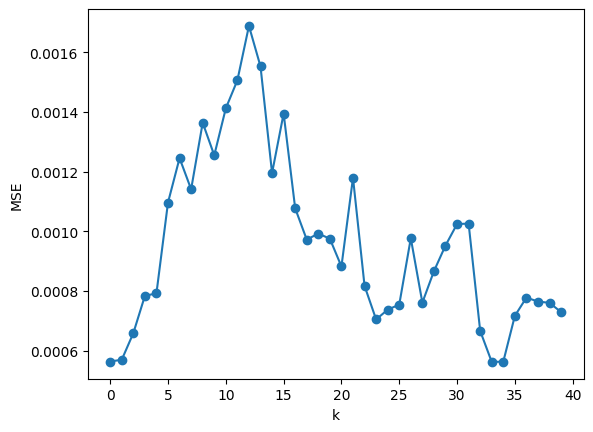

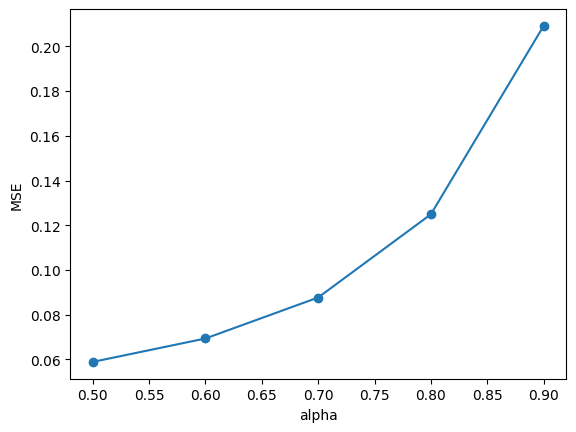

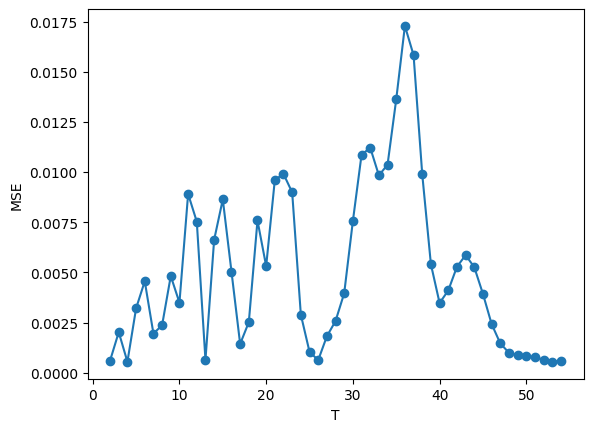

In [13]:
df_sarima_p_n_q = pd.read_csv(df_path_sarima)


def plot(df_sarima, column='mae'):
  dft = df_sarima.iloc[:line_trend.data.shape[0]]
  dfa = df_sarima.iloc[line_trend.data.shape[0]:-seasonal.data.shape[0]]
  dfs = df_sarima.iloc[-seasonal.data.shape[0]:]

  plt.plot(range(dft.shape[0]), dft[column], marker='o')
  plt.ylabel(column.upper())
  plt.xlabel('k')
  plt.show()

  plt.plot([.5, .6, .7, .8, .9], dfa[column], marker='o')
  plt.ylabel(column.upper())
  plt.xlabel('alpha')
  plt.show()

  plt.plot(range(2, dfs.shape[0] + 2), dfs[column], marker='o')
  plt.ylabel(column.upper())
  plt.xlabel('T')
  plt.show()

plot(df_sarima_p_n_q, 'mse')
# plot(df_sarima_p_n_q, 'aicc')

In [23]:
# Создаем пример DataFrame
df = pd.DataFrame({
    'y': [1, 4, 9, 16, 25]
})

# Дифференцируем столбец 'y' по 'x'
df['dy_dx'] = df['y'].diff()

print(df)

    y  dy_dx
0   1    NaN
1   4    3.0
2   9    5.0
3  16    7.0
4  25    9.0


In [27]:
df_sarima_p_n_q.iloc[:41]

,name,p,n,q,sp,sn,sq,m,aicc,bic,mae,mse,p_rmse
0,k=0,5,0,1,1,0,0,52,-257.025988,-235.945378,0.019719,0.000563,2.373573
1,k=1,5,0,1,1,0,0,52,-256.964979,-235.884369,0.018607,0.000569,2.385926
2,k=2,5,0,1,1,0,0,52,-256.562289,-235.481679,0.019820,0.000658,2.565996
3,k=3,5,0,1,1,0,0,52,-255.780493,-234.699883,0.021788,0.000783,2.798765
4,k=4,5,0,1,1,0,0,52,-255.511941,-234.431331,0.021915,0.000792,2.814256
5,k=5,5,0,1,1,0,0,52,-255.248462,-234.167852,0.027355,0.001096,3.311115
6,k=6,5,0,1,1,0,0,52,-254.395276,-233.314666,0.029535,0.001245,3.528687
7,k=7,5,0,1,1,0,0,52,-253.750849,-232.670239,0.027838,0.001141,3.377396
8,k=8,5,0,1,1,0,0,52,-253.526361,-232.445751,0.031024,0.001364,3.692826
9,k=9,5,0,1,1,0,0,52,-252.473219,-231.392609,0.029372,0.001255,3.542053


In [30]:
df_sarima_p_n_q['p_rmse'] = np.sqrt(df_sarima_p_n_q.mse) * 100
df_sarima_p_n_q.iloc[40:45].p_rmse.diff().describe()

,p_rmse
count,4.000000
mean,5.365126
std,3.679007
min,2.069964
25%,2.973150
50%,4.500516
75%,6.892491
max,10.389510


## analys

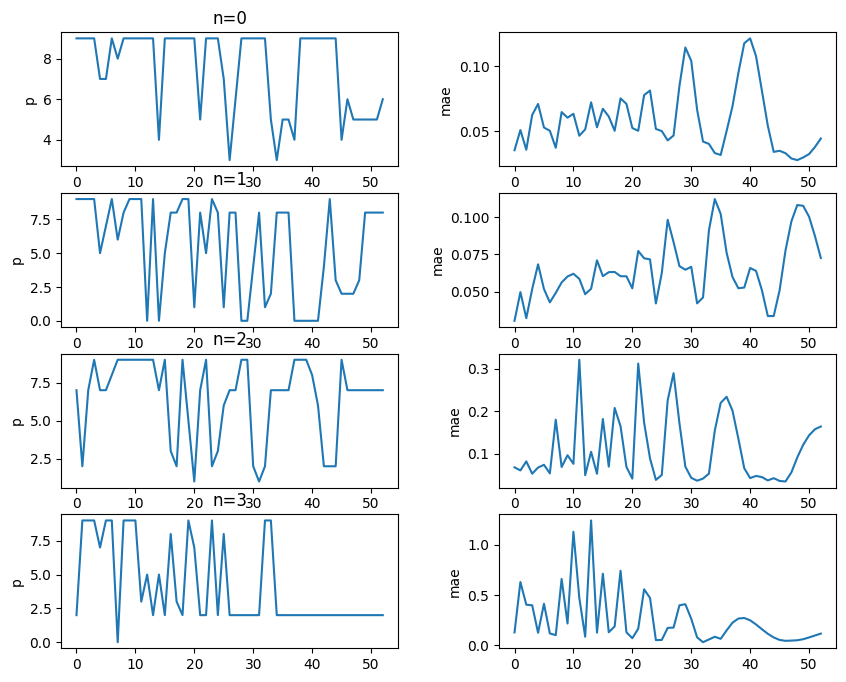

In [ ]:
data = []
data_p = []
data_p_mae = []
for n in df_sarima_p_n_0['n'].unique():
  for nm in name_seasonal:
    mask = (df_sarima_p_n_0['name'] == nm) & (df_sarima_p_n_0['n'] == n)
    dfs = df_sarima_p_n_0[mask].sort_values(by=['mae'], ascending=[True])
    data_p.append(dfs.iloc[0]['p'])
    data_p_mae.append(dfs.iloc[0]['mae'])
  data.append(data_p)
  data.append(data_p_mae)
  data_p, data_p_mae = [], []


titles = ['n=0', None, 'n=1', None, 'n=2', None, 'n=3', None]
ylabel = ['p', 'mae'] * 4
show = Show()
show.subplot_x(np.array(data), 2, titles, ylabels=ylabel)

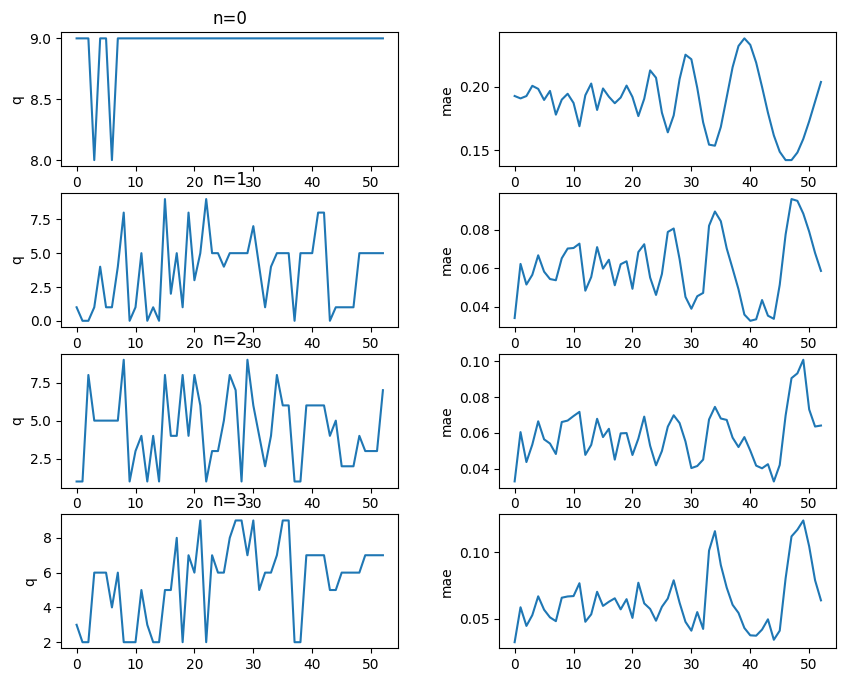

In [ ]:
data = []
data_p = []
data_p_mae = []
for n in df_sarima_0_n_q['n'].unique():
  for nm in name_seasonal:
    mask = (df_sarima_0_n_q['name'] == nm) & (df_sarima_0_n_q['n'] == n)
    dfs = df_sarima_0_n_q[mask].sort_values(by=['mae'], ascending=[True])
    data_p.append(dfs.iloc[0]['q'])
    data_p_mae.append(dfs.iloc[0]['mae'])
  data.append(data_p)
  data.append(data_p_mae)
  data_p, data_p_mae = [], []


titles = ['n=0', None, 'n=1', None, 'n=2', None, 'n=3', None]
ylabel = ['q', 'mae'] * 4
show = Show()
show.subplot_x(np.array(data), 2, titles, ylabels=ylabel)

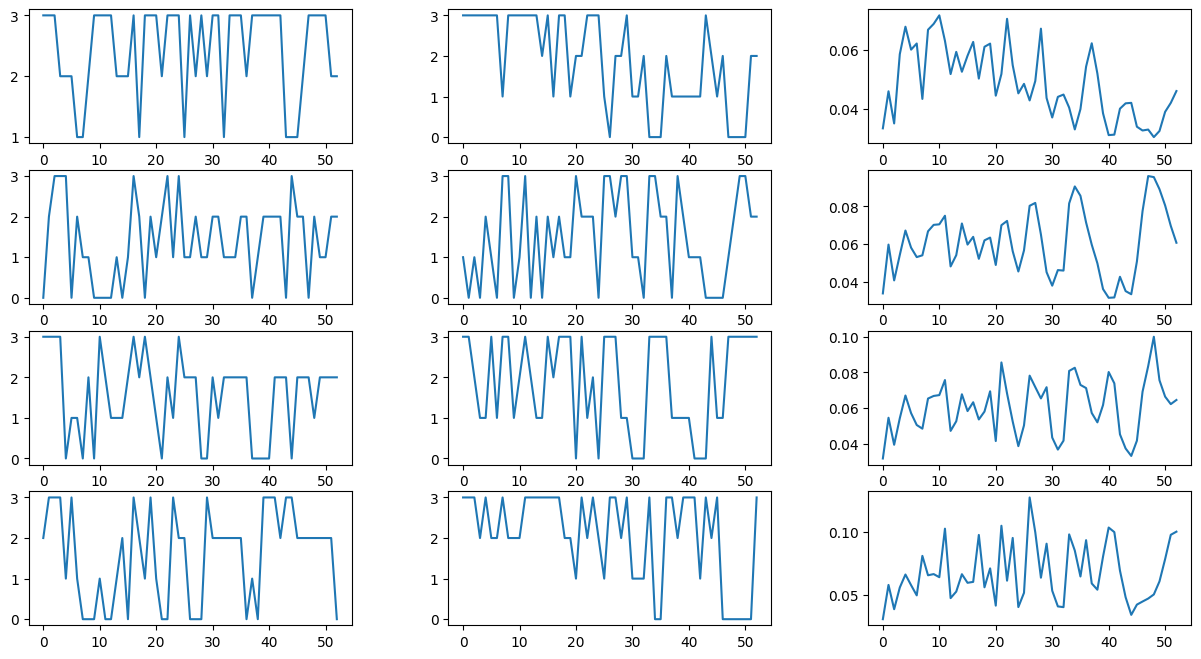

In [ ]:
data = []
data_p = []
data_p_mae = []
for n in df_sarima_p_n_q['n'].unique():
  for nm in name_seasonal:
    mask = (df_sarima_p_n_q['name'] == nm) & (df_sarima_p_n_q['n'] == n)
    dfs = df_sarima_p_n_q[mask].sort_values(by=['mae'], ascending=[True])
    data_p.append(dfs.iloc[0][['p', 'n', 'q']].values)
    data_p_mae.append(dfs.iloc[0]['mae'])
  data_p = np.array(data_p)
  data.append(data_p[:, 0])
  data.append(data_p[:, 2])
  data.append(data_p_mae)
  data_p, data_p_mae = [], []


titles = ['n=0', None, 'n=1', None, 'n=2', None, 'n=3', None]
ylabel = ['q', 'mae'] * 4
show = Show()
show.subplot_x(np.array(data), 3)#, titles, ylabels=ylabel)

## library

In [ ]:
class SubplotError(Exception):
  def __init__(self, message: str):
    super().__init__(message)

  @classmethod
  def all_arg_one_type(*args):
    types = set([type(arg) for arg in args[1:]])

    assert len(types) == 1, SubplotError(f'Arguments don`t have one type')

  @classmethod
  def shapeError(*args):
    for i in range(1, len(args) - 1, 2):
      assert args[i].shape == args[i + 1].shape, SubplotError(f'x and y must have same first dimension, {args[i].shape} and {args[i + 1].shape}')

from numpy.typing import NDArray

class Show():
    def __init__(self, base_figsize=(5, 2)) -> None:
        self.fig, self.axes = None, None
        self.shape, self.pos = None, [0, 0]
        self.base_figsize = base_figsize  # базовый размер для одного подграфика

    def create_subplot(self, nrows: int, ncols: int) -> None:
        self.shape = [nrows, ncols]
        # Автоматический расчет размера фигуры на основе количества подграфиков
        fig_width = self.base_figsize[0] * ncols
        fig_height = self.base_figsize[1] * nrows
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))

    def add_subplot(self, xvalue: NDArray, yvalue: NDArray, **kwargs):
        if self.shape[0] == 1 and self.shape[1] == 1:
            self.axes.plot(xvalue, yvalue, **kwargs)
        elif self.shape[0] == 1 or self.shape[1] == 1:
            self.axes[self.pos[0] if self.shape[0] > 1 else self.pos[1]].plot(xvalue, yvalue, **kwargs)
        else:
            self.axes[self.pos[0], self.pos[1]].plot(xvalue, yvalue, **kwargs)

        if self.pos[1] + 1 < self.shape[1]:
            self.pos[1] += 1
        else:
            self.pos[0] += 1
            self.pos[1] = 0

    def subplot(self, xvalues: NDArray, yvalues: NDArray, nrows: int, ncols: int):
        SubplotError.shapeError(xvalues, yvalues)
        self.create_subplot(nrows, ncols)

        for i in range(xvalues.shape[0]):
            self.add_subplot(xvalues[i], yvalues[i])

        plt.subplots_adjust(wspace=0.3, hspace=0.2)
        plt.show()

    def subplot_x(self, yvalues: NDArray, ncols: int) -> None:
        xvalues = [np.arange(yvalues.shape[1])] * yvalues.shape[0]
        nrows = mt.ceil(yvalues.shape[0] / ncols)
        self.subplot(np.array(xvalues), yvalues, nrows, ncols)

    def one_plot(self, y: NDArray, labels: NDArray, x: NDArray = None) -> None:
        if x is None:
          x = np.array([np.arange(y.shape[1])] * y.shape[0])

        SubplotError.shapeError(x, y, labels)

        for i, yv in enumerate(y):
          plt.plot(x[i], yv, label=labels[i])

        plt.legend()
        plt.show()